In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import d2l.torch as d2l

In [2]:
# 使用预训练的模型来初始化卷积层的参数
pretrained_net = torchvision.models.resnet18(pretrained=True)
list(pretrained_net.children())[-3:]

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\thinkpad/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

In [3]:
# 但由于任务为sementic segmentation, 因此去除最后的全局平均池化层与全连接层
net  = nn.Sequential(*list(pretrained_net.children())[:-2])

In [4]:
# 随机生成一个变量来查看输入输出的结构变化
X = torch.rand(size=(1, 3, 320, 480))
net(X).shape

torch.Size([1, 512, 10, 15])

In [5]:
# 接下来, 使用 1×1 卷积层将输出通道数转换为Pascal VOC2012数据集的类数（21类）, 直接将512的通道压缩到21其实会损失不少特征信息, 
# 但为了降低计算复杂度以提升模型推理速度, 还是选择强行压缩
num_class = 21
net.add_module('final_conv', nn.Conv2d(512, num_class, kernel_size=1))
# 最后, 需要将特征图的高度和宽度增加32倍，从而将其变回输入图像的高和宽
# 由于 (320−64+16×2+32)/32=10 且 (480−64+16×2+32)/32=15 , 所以构造一个步幅为 32 的转置卷积层，
# 并将卷积核的高和宽设为 64 ，填充为 16 则转置卷积核会将输入的高和宽分别放大32倍
net.add_module('transpose_conv', nn.ConvTranspose2d(num_class, num_class, kernel_size=64, padding=16, stride=32))

In [6]:
# 双线性插值为常用的上采样方法, 通过双线性插值来初始化转置卷积层的参数
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = (torch.arange(kernel_size).reshape(-1, 1), torch.arange(kernel_size).reshape(1, -1))
    filt = (1 - torch.abs(og[0] - center) / factor) *  (1 - torch.abs(og[1] - center) / factor)
    weight = torch.zeros((in_channels, out_channels, kernel_size, kernel_size))
    weight[range(in_channels), range(out_channels), :, :] = filt
    return weight

input image shape: torch.Size([561, 728, 3])
output image shape: torch.Size([1122, 1456, 3])


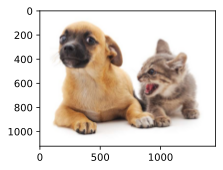

In [9]:
# 生成一个转置卷积简单测试一下参数初始化的正确性
conv_trans = nn.ConvTranspose2d(3, 3, kernel_size=4, padding=1, stride=2, bias=False)
conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4));
img = torchvision.transforms.ToTensor()(d2l.Image.open('../img/catdog.jpg'))
X = img.unsqueeze(0)  # 增加一个batch_size维度
Y = conv_trans(X)
out_img = Y[0].permute(1, 2, 0).detach()
d2l.set_figsize()
print('input image shape:', img.permute(1, 2, 0).shape)
d2l.plt.imshow(img.permute(1, 2, 0));
print('output image shape:', out_img.shape)
d2l.plt.imshow(out_img);

In [12]:
# 对FCN中的转置卷积层赋权重
W = bilinear_kernel(num_class, num_class, 64)
net.transpose_conv.weight.data.copy_(W);

In [ ]:
# 取VOC数据集
import os
def load_data_voc(batch_size, crop_size):
    """Load the VOC semantic segmentation dataset."""
    voc_dir = d2l.download_extract('voc2012', os.path.join('VOCdevkit', 'VOC2012'))
    num_workers = d2l.get_dataloader_workers()
    train_iter = torch.utils.data.DataLoader(
        d2l.VOCSegDataset(True, crop_size, voc_dir), batch_size, shuffle=True,
        drop_last=True, num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(
        d2l.VOCSegDataset(False, crop_size, voc_dir), batch_size, drop_last=True,
        num_workers=num_workers)
    return train_iter, test_iter

batch_size, crop_size = 32, (320, 480)
train_iter, test_iter = load_data_voc(batch_size, crop_size)

In [ ]:
def loss(inputs, targets):
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)  # 现在的输出结果是矩阵, 因此在高宽上都做一次均值

num_epochs, lr, wd, devices = 5, 0.001, 1e-3, d2l.try_all_gpus()
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [ ]:
# 对结果的预测
def predict(img):
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    pred = net(X.to(devices[0])).argmax(dim=1)  # 由于在各像素的输出通道维上保留各类的概率, 所以这里argmax的dim取1
    return pred.reshape(pred.shape[1], pred.shape[2])